# PDE Constrained Optimisation for "New insights into the kinetics of metal|electrolyte interphase growth in solid-state-batteries via an operando XPS analysis - part II: modelling"

In [106]:
cd(@__DIR__); import Pkg; Pkg.activate(".")

using DifferentialEquations, Flux, Optim,  DiffEqSensitivity, DiffEqFlux, SpecialFunctions, Polynomials, SpecialPolynomials , CairoMakie

  Activating project at `C:\Users\nw7g1\OneDrive - Imperial College London\PhD Year 1\MIT placement\Constrained_optimisation`


### Import experimental data, functions and constants 

In [107]:
k_B = 8.617333262145*1e-5 #eV/K

#Data NZSPAS
ext_t_AS = [0:24:264;]
Na0_area_AS = [   0,  1295.78, 29612.7 , 50739.1 , 63105.2 , 71138.9 , 75169.8 , 79046.  , 85446.  , 88556.  , 91779.  , 95593]
Norm_AS_area = Na0_area_AS/maximum(Na0_area_AS) 
Na1_position_AS = [1074.03,1074.03, 1073.95, 1073.91, 1073.88, 1073.86, 1073.86, 1073.83, 1073.82, 1073.81, 1073.8, 1073.82 ]
Na1_position_AS = Na1_position_AS - ones(length(Na1_position_AS)) * Na1_position_AS[1]


#Data NZSPpolished
ext_t_polished =  [0:18:236;]
Na0_area_polished = [  0, 59548.4, 151923, 175832, 180140, 191638, 194608, 196172, 199636, 203738, 205571, 204802, 206666, 209957]
Norm_polished_area = Na0_area_polished/maximum(Na0_area_polished) #/ 1.12
Na1_position_polished = [ 1073.95, 1073.86, 1073.62, 1073.43, 1073.24, 1073.11, 1073.03, 1072.95, 1072.89, 1072.86, 1072.84, 1072.81, 1072.78, 1072.78]
Na1_position_polished = Na1_position_polished - ones(length(Na1_position_polished)) * Na1_position_polished[1]

function i_CIET(c,V,L,k)
    V_f = (V + k_B*300*log((1-c)/c))
    L_f = L*k_B*300
    a = 1+ sqrt(L_f)
    k*sqrt(pi*L_f)*(1-c)*((1-c)/(1+exp(V_f/(k_B*300)))-c/(1+exp(-V_f/(k_B*300)))) *erfc((L_f-sqrt(a+(V_f/(k_B*300))^2))/2*sqrt(L_f))
end

function i_CIET_SEI(c,c_SEI,V,L,k)
    V_f = (V + k_B*300*log((1-c)/c))
    L_f = L*k_B*300
    a = 1+ sqrt(L_f)
    k*sqrt(pi*L_f)*(1-c-c_SEI)*((1-c-c_SEI)/(1+exp(V_f/(k_B*300)))-c/(1+exp(-V_f/(k_B*300)))) *erfc((L_f-sqrt(a+(V_f/(k_B*300))^2))/2*sqrt(L_f))
end


i_CIET_SEI (generic function with 1 method)

## 1. NZSPAS system

### 1.1. Set up ODE problem 

In [108]:
function rhs(du,u,k,t)
    k1f,  k2f , V, L = k
    du[1] =  i_CIET(u[1],V, L, k1f ) - k2f * u[1] 
    du[2] = k2f * u[1]  
end

u0 = [1e-9, 0]     #intial starting values
k = ( 100, 1 , 1, 100)   #initial guess
tspan = (0.0,300.0)   
tsteps = ext_t_AS
prob = ODEProblem(rhs,u0,tspan,k)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 300.0)
u0: 2-element Vector{Float64}:
 1.0e-9
 0.0

### 1.2. Create loss function

In [109]:
function loss(p)
    sol = solve(prob, Tsit5(), p=p[1:4], saveat = tsteps)
    loss = sum(abs2, (Array(sol)[1,:].+Array(sol)[2,:]) .- p[6].*Norm_AS_area)
    loss += sum(abs2, p[5].*Array(sol)[1,:] .- Na1_position_AS)
    return loss
end

callback = function (p, l)
    display(l)
    return false
end

#25 (generic function with 1 method)

### 1.3. Now we optimise 

In [110]:
p0 = [0.0069,  0.0013,-0.1, 6, -0.3, 0.78] # initial guesses for k
result_ode = DiffEqFlux.sciml_train(loss, p0, ADAM(0.0001), cb = callback, maxiters = 100)
result_ode

0.4899237561299782

0.4616549497613467

0.43460565480093005

0.4087818271339443

0.3841873739479024

0.3608240226532105

0.338691032808216

0.31778434178693427

0.2980941715316837

0.2796034187402553

0.2623053482120524

0.24617983500741478

0.23120159492520703

0.21733974162551783

0.20455735776489906

0.19281120515989436

0.1820512011032938

0.17222029644266412

0.1632549939788871

0.15508602137823

0.14763946094473265

0.14083846515014467

0.13460533280474776

0.12886389845215668

0.1235416399236367

0.1185716716667066

0.11389422350077698

0.10945751686944255

0.10521809744983678

0.10114067500233934

0.09719760724513812

0.09336817460829924

0.08963771350410006

0.08599674072171333

0.0824400986223361

0.07896613987018346

0.07557599492188256

0.0722728969911907

0.06906159159958433

0.06594780990522117

0.06293776760231932

0.06003772763268066

0.057253631303623785

0.05459076025714955

0.05205344786900985

0.049644822720698145

0.04736661352322607

0.04521900309610442

0.0432005381544363

0.04130810590857083

0.03953698548905334

0.0378809666408519

0.03633254769174354

0.03488319617486668

0.03352367145263126

0.03224438437059912

0.031035779876807768

0.02988870967005231

0.02879477549213212

0.02774660954552135

0.026738087878542063

0.025764442813562924

0.02482228821112011

0.02390954724732198

0.023025308649062975

0.022169614826916578

0.021343211135544264

0.02054727562936797

0.019783159332154958

0.019052142349324817

0.01835523316993432

0.01769301755347338

0.017065565419299607

0.016472391323917757

0.01591247053555809

0.015384302823192905

0.014886004829716004

0.01441543575910103

0.013970323402597355

0.013548392625742384

0.01314748012573657

0.012765625374572697

0.012401137289810477

0.012052626908299304

0.011719015581297614

0.011399511958475307

0.011093571416575665

0.010800841106957785

0.01052109673005431

0.010254178155272962

0.00999993236164131

0.009758166511567216

0.009528613502531574

0.009310913844039023

0.00910461092407067

0.00890916117882398

0.008723953610545591

0.008548335839414018

0.008381644280589611

0.008223231868891118

0.008223231868891118

u: 6-element Vector{Float64}:
  0.011552857821988735
  0.00013775908245736943
 -0.10523950747490468
  6.0053417718881485
 -0.30650033160016366
  0.7754214581171052

### 1.4. Plot results

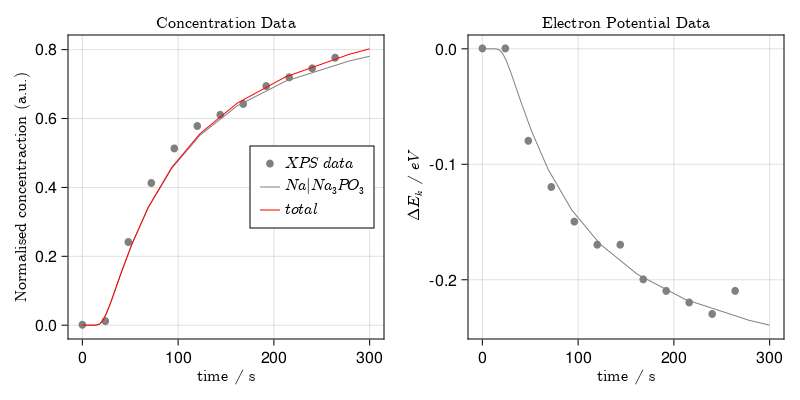

In [111]:
prob = ODEProblem(rhs,u0,tspan,result_ode)
sol = solve(prob)

fig = Figure(resolution = (800, 400))

ax = Axis(fig[1, 1],
    title = L"Concentration Data$$",
    xlabel = L"time /   s$$",
    ylabel = L"Normalised concentraction (a.u.)$$"
)
scat1 = scatter!(fig[1,1],ext_t_AS,result_ode[6]*Norm_AS_area, color = :grey, marker = :circle, markersize = 10, label = L"$XPS \;data$")
line1 = lines!(fig[1,1], sol.t,Array(sol)[1,:], color = :grey, linewidth = 1, label = L"$Na|Na_3PO_3$")
line2 = lines!(fig[1,1], sol.t,Array(sol)[1,:] + Array(sol)[2,:], color = :red, linewidth = 1, label = L"$total$")
axislegend(position = :rc) # Apply legend

ax = Axis(fig[1, 2],
    title = L"Electron Potential Data$$",
    xlabel = L"time /   s$$",
    ylabel = L"$\Delta E_k $ /   $eV$"
) # Using L to get LaTex formating, the $$ is so we can have only text
scat1 = scatter!(fig[1,2],ext_t_AS,Na1_position_AS, color = :grey,  marker = :circle, markersize = 10, label = "Scatter 1")
line2 = lines!(fig[1,2],sol.t, result_ode[5]*Array(sol)[1,:], color = :grey, linewidth = 1, label = "Line 2")

fig 

## 2. NZSPpoliahsed system

### 2.1. Set up ODE problem 

In [112]:
function rhs(du,u,k,t)
    k1f, k2f, k3f , V, L = k
    du[1] =  i_CIET_SEI(u[1], u[2], V, L, k1f) - k2f * u[1]  -  k3f * u[1] 
    du[2] = k2f * u[1] 
    du[3] = k3f * u[1] 
end

u0 = [1e-9, 0, 0]
k = (0.015, 0.01030, 0.00933, -0.09176, 6)
tspan = (0.0,300.0)
tsteps = ext_t_polished
prob = ODEProblem(rhs,u0,tspan,k)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 300.0)
u0: 3-element Vector{Float64}:
 1.0e-9
 0.0
 0.0

### 2.2. Create loss function

In [113]:
function loss(p)
    sol = solve(prob, Tsit5(), p=p[1:5], saveat = tsteps)
    loss = sum(abs2, (Array(sol)[1,:].+Array(sol)[2,:].+Array(sol)[3,:]) .- p[8].*Norm_polished_area)
    loss += sum(abs2, (p[6].*Array(sol)[1,:] + p[7].*Array(sol)[2,:]).- Na1_position_polished)
    return loss
end

callback = function (p, l)
    display(l)
    return false
end

#27 (generic function with 1 method)

### 2.3. Now we optimise 

In [114]:
p0 = [0.0418, 0.0263, 0.00279, -0.1042, 6.015, -0.3182, -1.326996,0.892] #[0.0349632,  0.03296, 0.00429, -0.09, 6, -0.3, -1.3]  #[ 0.001, 0.0011,  0.0017,  0.00221, -0.1, 0.2]
result_ode = DiffEqFlux.sciml_train(loss, p0, ADAM(0.0001), cb = callback, maxiters = 100)
result_ode 

0.05628512298386403

0.0534756778317347

0.0508804233420172

0.04849677107105682

0.04631626234725121

0.04432416127467319

0.04250510463280549

0.04084881463486341

0.03934930560491197

0.038001713417157294

0.03680033806533074

0.03573788555211223

0.03480531721490052

0.033991998368651806

0.033286029365412764

0.03267469837228952

0.03214500038337835

0.031684155778916576

0.0312800627502507

0.030921637583172755

0.030599014537705166

0.03030361525662446

0.03002811457396649

0.02976633696213422

0.02951312682683422

0.029264217568029733

0.029016121872684503

0.02876604957568576

0.028511852539105022

0.02825198449081509

0.02798546673712794

0.027711851910845686

0.027431175161602372

0.027143893315788696

0.026850812823200426

0.026553009590661376

0.026251748869370456

0.025948403572273043

0.02564438188897163

0.025341060149367794

0.025039727454869192

0.024741539953537013

0.02444748839284793

0.024158376209448038

0.023874806932341147

0.023597184826579316

0.023325721908607374

0.023060454034929383

0.022801261276723182

0.022547896003808826

0.02230001089869586

0.02205719021954565

0.021818980207671097

0.02158491930274094

0.021354562958180282

0.02112750793106672

0.020903409067094744

0.020681991603571218

0.020463059315479443

0.020246494548623054

0.020032255691323178

0.019820369245446626

0.019610917610119013

0.019404026808967877

0.019199850200935883

0.01899855438173302

0.018800304736975377

0.018605253270458935

0.018413528136191265

0.018225227281164942

0.018040413174389015

0.01785911219203824

0.01768131438118916

0.01750697681407431

0.01733602939859248

0.017168389418921334

0.01700395826078234

0.01684262760387727

0.0166842889398134

0.01652883760866261

0.01637617624990405

0.01622621888427446

0.016078889290813796

0.015934123432670175

0.015791867343599025

0.015652074667555624

0.015514705276681837

0.015379721522559765

0.015247086978141696

0.015116762406573999

0.014988706072303275

0.014862871036768229

0.01473920491974249

0.014617650663525678

0.014498146052705031

0.014380625432394068

0.014265020700269151

0.014151262492682483

0.014039282464089243

0.01392901309141523

0.01392901309141523

u: 8-element Vector{Float64}:
  0.049194273287829146
  0.02185231356269137
 -0.0003138493991641121
 -0.09493709733807307
  6.0233185095741355
 -0.3085671682492644
 -1.3328727057282985
  0.8882360107922126

## 2.4. Plot results

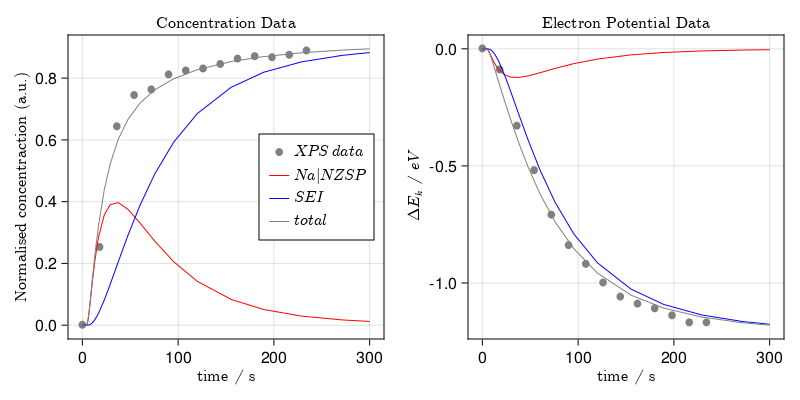

In [115]:
prob = ODEProblem(rhs,u0,tspan,result_ode)
sol = solve(prob)

fig = Figure(resolution = (800, 400))

ax = Axis(fig[1, 1],
    title = L"Concentration Data$$",
    xlabel = L"time /   s$$",
    ylabel = L"Normalised concentraction (a.u.)$$"
)
scat1 = scatter!(fig[1,1],ext_t_polished, result_ode[8]*Norm_polished_area, color = :grey, marker = :circle, markersize = 10, label = L"$XPS \;data$")
line1 = lines!(fig[1,1], sol2.t,Array(sol2)[1,:], color = :red, linewidth = 1, label = L"$Na|NZSP$")
line2 = lines!(fig[1,1], sol2.t,Array(sol2)[2,:], color = :blue, linewidth = 1, label = L"$SEI$")
line3 = lines!(fig[1,1], sol2.t,Array(sol2)[1,:]+ Array(sol2)[2,:], color = :grey, linewidth = 1, label = L"$total$")
axislegend(position = :rc) # Apply legend

ax = Axis(fig[1, 2],
    title = L"Electron Potential Data$$",
    xlabel = L"time /   s$$",
    ylabel = L"$\Delta E_k $ /   $eV$"
) # Using L to get LaTex formating, the $$ is so we can have only text
scat1 = scatter!(fig[1,2],ext_t_polished, Na1_position_polished, color = :grey,  marker = :circle, markersize = 10)
line1 = lines!(fig[1,2], sol2.t, result_ode[6]*Array(sol2)[1,:], color = :red, linewidth = 1)
line2 = lines!(fig[1,2], sol2.t, result_ode[7]*Array(sol2)[2,:], color = :blue, linewidth = 1)
line3 = lines!(fig[1,2], sol2.t, result_ode[6]*Array(sol2)[1,:]+ result_ode[7]*Array(sol2)[2,:], color = :grey, linewidth = 1)

fig 